# Vehicle Detection Project

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

---

## Rubric Points

Here I will consider the rubric points individually and describe how I addressed each point in my implementation.

In [16]:
# First load the libraries and load the images

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import random

from itertools import product
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label as image_label

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

    Vehicle images count: 8792
Non-Vehicle images count: 8968


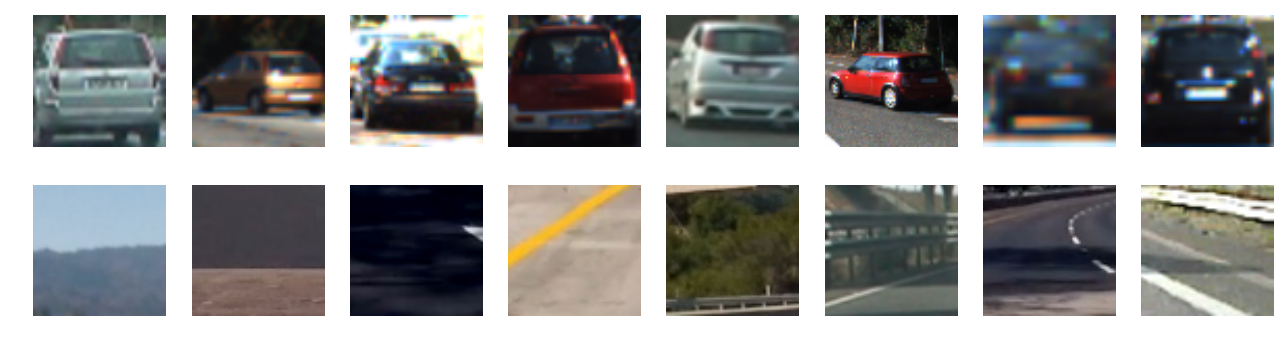

In [2]:
vehicle_images = glob.glob('dataset/vehicles/**/*')
non_vehicle_images = glob.glob('dataset/non-vehicles/**/*')

print('    Vehicle images count:', len(vehicle_images))
print('Non-Vehicle images count:', len(non_vehicle_images))

def load_images(images, container):
    """ Read images and append to the container. """
    for filename in images:
        image = mpimg.imread(filename)
        container.append(image)


# Get some sample images for test
TEST_SAMPLES = 8
vehicle_samples = []
non_vehicle_samples = []
load_images(random.sample(vehicle_images, TEST_SAMPLES), vehicle_samples)
load_images(random.sample(non_vehicle_images, TEST_SAMPLES), non_vehicle_samples)

    
class Processor():
    """ Processor interface. """
    def process(self, image):
        raise NotImplementedError


class NoopProcessor(Processor):
    """ Processor that do nothing. """
    def process(self, image):
        return image


def test_on_samples(processor, cmap=None):
    def show_images(samples, offset=0):
        for i, image in enumerate(samples, 1):
            image = processor.process(np.copy(image))
            plt.subplot(2, TEST_SAMPLES, i + offset)
            plt.axis('off')
            plt.imshow(image, cmap=cmap)
            
    plt.figure(figsize=(TEST_SAMPLES * 2, 4))
    show_images(vehicle_samples)
    show_images(non_vehicle_samples, TEST_SAMPLES)
    plt.show()

    
# Show the sample images
test_on_samples(NoopProcessor())

## Writeup / README

### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one. You can submit your writeup as markdown or pdf.

This notebook is just the code and the writeup document.

## Histogram of Oriented Gradients (HOG)

### 1. Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.

I have used `skimage.feature.hog` function to extract the HOG features, and I've set some parameters to tune them in the next code sections.

In [3]:
class HOGProcessor(Processor):
    """ Return the hog feauters. """
    def __init__(self, orient, pix_per_cell, cell_per_block, visualise=False):
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.visualise = visualise
    
    def process(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        result = hog(
            gray,
            orientations=self.orient,
            pixels_per_cell=(self.pix_per_cell,self.pix_per_cell),
            cells_per_block=(self.cell_per_block, self.cell_per_block),
            visualise=self.visualise,
            transform_sqrt=False,
            feature_vector=True  # Return the data as a feature vector by calling .ravel() on the result just before returning.
        )
        
        if self.visualise:
            # If set visualise to True, the result will be the features and hog_image
            return result[1]
        else:
            return result
        
class CSpaceConvertor():
    """ Convert the image to the specified cspace. """
    def cspace_convert(self, image):
        if self.cspace != 'RGB':
            if self.cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif self.cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif self.cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif self.cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif self.cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
            
        return feature_image 

        
class BinSpatialProcessor(Processor, CSpaceConvertor):
    """ Return the binned color features. """
    def __init__(self, spatial, cspace):
        self.spatial = spatial
        self.cspace = cspace
        
    def process(self, image):
        feature_image = self.cspace_convert(image)
        features = cv2.resize(feature_image, (self.spatial, self.spatial)).ravel()
        return features

        
class ColorHistProcessor(Processor, CSpaceConvertor):
    """ Return the histogram of color channels separately. """
    def __init__(self, nbins, cspace, bins_range=(0, 256)):
        self.nbins = nbins
        self.bins_range = bins_range
        self.cspace = cspace
        
    def process(self, image):
        feature_image = self.cspace_convert(image)
        channel1_hist = np.histogram(feature_image[:,:,0], bins=self.nbins, range=self.bins_range)
        channel2_hist = np.histogram(feature_image[:,:,1], bins=self.nbins, range=self.bins_range)
        channel3_hist = np.histogram(feature_image[:,:,2], bins=self.nbins, range=self.bins_range)
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        return hist_features


class FeaturesConcatProcessor(Processor):
    """ Concatenate the features of subprocessors. """
    def __init__(self, *processors):
        self.processors = processors
        
    def process(self, image):
        features = [processor.process(image) for processor in self.processors]
        return np.concatenate(features)

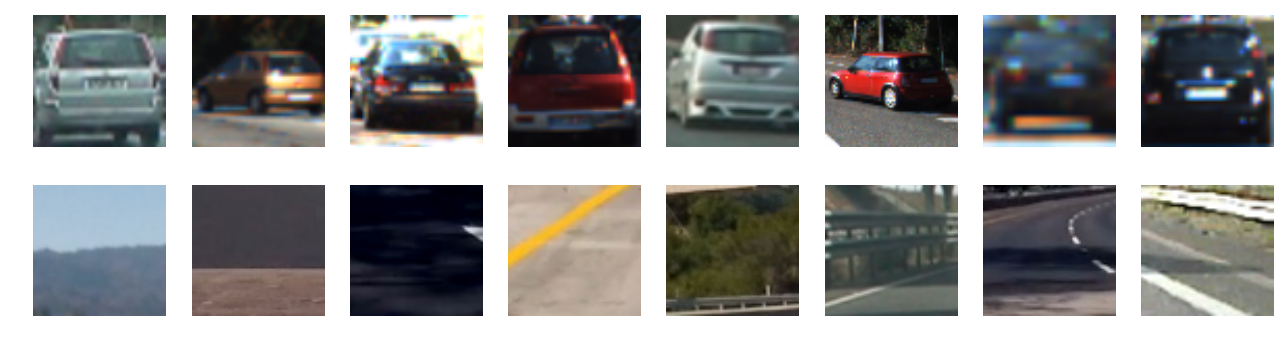

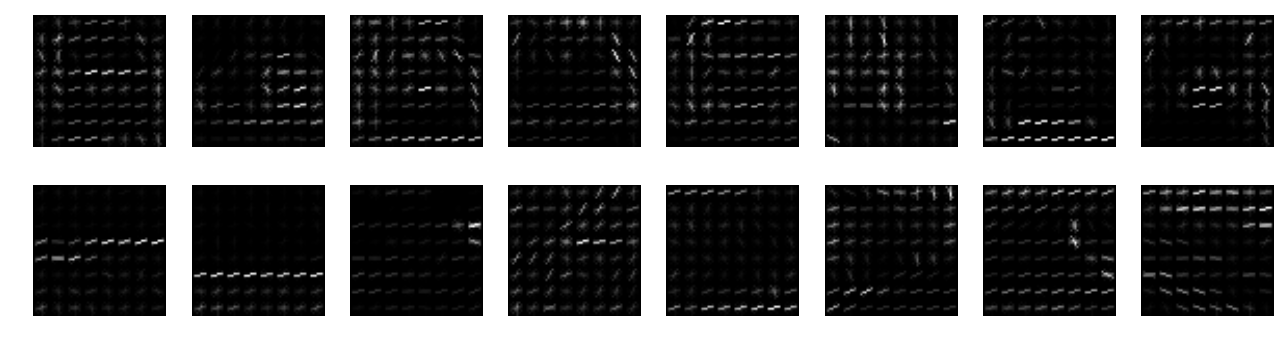

In [4]:
test_on_samples(NoopProcessor())
test_on_samples(HOGProcessor(orient=9, pix_per_cell=8, cell_per_block=2, visualise=True), cmap='gray')

### 2. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

The vehicle samples is almost equals to the non-vehicle samples, so I just load and split them using the sklearn.train_test_split.  
I've also flip the samples left to right, them I've got 30K+ samples.

In [133]:
# Load all the images into memory
temp_vehicle_images = []
load_images(vehicle_images, temp_vehicle_images)

temp_non_vehicle_images = []
load_images(non_vehicle_images, temp_non_vehicle_images)

X = np.vstack((temp_vehicle_images, temp_non_vehicle_images))
y = np.hstack((np.ones(len(vehicle_images), dtype=np.int), np.zeros(len(non_vehicle_images), dtype=np.int)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# Clean up the temp images
del(temp_vehicle_images)
del(temp_non_vehicle_images)

print('The shape of features:', X.shape, 'with data type:', X.dtype)
print('The shape of labels  :', y.shape)

The shape of features: (17760, 64, 64, 3) with data type: float32
The shape of labels  : (17760,)


In [27]:
# Generate new samples

flip_X = np.array([np.fliplr(image) for image in X_train])

X_train = np.vstack([X_train, flip_X])
y_train = np.concatenate([y_train, y_train])
del(flip_X)

X_train, y_train = shuffle(X_train, y_train)

print('The shape of training features:', X_train.shape, 'with data type:', X_train.dtype)
print('The shape of training labels  :', y_train.shape)

The shape of training features: (33744, 64, 64, 3) with data type: float32
The shape of training labels  : (33744,)


In [121]:
class SVCClassifier():
    N_PREDICT = 10
        
    def __init__(self, processor, class_weight='balanced', pca=None):
        self.processor = processor
        self.scaler = StandardScaler()
        self.svc = LinearSVC(class_weight=class_weight)
        if pca:
            self.pca = PCA(n_components=pca)
        else:
            self.pca = None
        
    def fit(self, features, labels):
        t = time.time()
        # Fit the scaler
        X = [
            self.processor.process(feature) for feature in features
        ]
        
        if self.pca:
            self.pca.fit(X)
            X = self.pca.transform(X)
            
        self.scaler.fit(X)
        scaled_X = self.scaler.transform(X)
        
        # Fit the SVC classifier
        self.svc.fit(scaled_X, labels)
        t2 = time.time()
        print(round(t2 - t, 2), 'Seconds to train ...')
        
    def pre_process(self, features, feature_processed=False):
        if not feature_processed:
            features = [self.processor.process(feature) for feature in features]
        if self.pca:
            features = self.pca.transform(features)
        scaled_features = self.scaler.transform(features)
        return scaled_features
        
    def score(self, features, labels):
        _score = self.svc.score(self.pre_process(features), labels)
        print('Test Accuracy =', round(_score, 4))
        t = time.time()
        self.predict(features[:self.N_PREDICT])
        t2 = time.time()
        print(round(t2 - t, 5), 'Seconds to predict', self.N_PREDICT, 'labels')
        return _score
        
    def predict(self, features, feature_processed=False):
        return self.svc.predict(self.pre_process(features, feature_processed))

And then, I have implemented a `SVCClassifier` class to combined the bin_color, color_hist, and HOG features.  
I have try every parameter combinations in the above code cell. Small dataset first and the large dataset to confirm.

First I have tested the cspace with spatial = 32 ,nbins = 32 ,orient = 9 ,pix_per_cell = 8 ,cell_per_block = 2,  
**HSV and HLS are obviously better than the others.**

Then I have tested the spartial with cspace in (HSV, HLS), nbins = 32 ,orient = 9 ,pix_per_cell = 8 ,cell_per_block = 2,  
**Reduce the spatial can reduce the training time, but no effect for the predict time.  
Spatial between 8 to 32 is better than others.**

Then, the nbins with spatial = 8 ,cspace = HSV ,orient = 9 ,pix_per_cell = 8 ,cell_per_block = 2,  
**nbin = 8 has 99% accuracy for the large training set, and nbins = 128 is 0.2% better.**

Then, the orient with spatial = 8 ,cspace = HSV ,nbins = 8 , pix_per_cell = 8 ,cell_per_block = 2,  
**No effect for the training and predict time, looks like overfit at orient = 10.**

Test the pix_per_cell and cell_per_block.  
**Small parameter will get a memory error. And only the 8, 2 combination is better than others.**

At last, try the best parameters on the full dataset.
And here is the last output:
```
spatial = 32 ,cspace = HSV ,nbins = 64 ,orient = 9 ,pix_per_cell = 8 ,cell_per_block = 2
29.74 Seconds to train ...
Test Accuracy = 0.9747
0.01404 Seconds to predict 10 labels

spatial = 32 ,cspace = HSV ,nbins = 128 ,orient = 9 ,pix_per_cell = 8 ,cell_per_block = 2
28.99 Seconds to train ...
Test Accuracy = 0.982
0.01346 Seconds to predict 10 labels

spatial = 32 ,cspace = HLS ,nbins = 64 ,orient = 9 ,pix_per_cell = 8 ,cell_per_block = 2
29.32 Seconds to train ...
Test Accuracy = 0.9741
0.01492 Seconds to predict 10 labels

spatial = 32 ,cspace = HLS ,nbins = 128 ,orient = 9 ,pix_per_cell = 8 ,cell_per_block = 2
29.24 Seconds to train ...
Test Accuracy = 0.9825
0.01542 Seconds to predict 10 labels
```

In [151]:
# Test for all the parameter combinations
def test_classifier_parameters(spatial, cspace, nbins, orient, pix_per_cell, cell_per_block):
    print('spatial =', spatial, ',cspace =', cspace, ',nbins =', nbins, ',orient =', orient, ',pix_per_cell =',
          pix_per_cell, ',cell_per_block =', cell_per_block)
    classifier = SVCClassifier(FeaturesConcatProcessor(
            BinSpatialProcessor(spatial=spatial, cspace=cspace),
            ColorHistProcessor(nbins=nbins, cspace=cspace),
            HOGProcessor(orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block),
    ), class_weight={1: 1, 0: 5})
    classifier.fit(X_train, y_train)
    classifier.score(X_test, y_test)
    print()
    
for parameters in product(
    (32,),  # spatial
    ('HLS',),  # cspace
    (64,),  # nbins
    (9,),  # orient
    (8,),  # pix_per_cell
    (2,),  # cell_per_block
):
    test_classifier_parameters(*parameters)

spatial = 32 ,cspace = HLS ,nbins = 64 ,orient = 9 ,pix_per_cell = 8 ,cell_per_block = 2
36.53 Seconds to train ...
Test Accuracy = 0.9786
0.01572 Seconds to predict 10 labels



In [170]:
# Try to use the PCA function.
def test_classifier_with_pca(pca):
    classifier = SVCClassifier(FeaturesConcatProcessor(
        ColorHistProcessor(nbins=64, cspace='HLS'),
        HOGProcessor(orient=9, pix_per_cell=8, cell_per_block=2),
    ), pca=pca)
    classifier.fit(X_train, y_train)
    classifier.score(X_test, y_test)
    print()
    
test_classifier_with_pca(100)
test_classifier_with_pca(200)
test_classifier_with_pca(500)

34.4 Seconds to train ...
Test Accuracy = 0.9786
0.0164 Seconds to predict 10 labels

31.56 Seconds to train ...
Test Accuracy = 0.982
0.01823 Seconds to predict 10 labels

39.12 Seconds to train ...
Test Accuracy = 0.9786
0.01684 Seconds to predict 10 labels



## Sliding Window Search

### 1. Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

I've pre-calculate the color histogram and hog features for each cell, and use the sliding window to combined the features of cells in this windows, none of histogram and HOG features will be calculate repeatly.  
At first, I use three size of scales: 0.5, 1, 2. But the small scales has huge of false positives, so I've droped it.  
And then I've try to increase the `cells_per_step` parameter to reduce the number of windows, but if this value is greater than 2, sometimes I can't detect the vehicles well.

In [118]:
ORIENT = 9
PIX_PER_CELL = 8
CELL_PER_BLOCK = 2
SPATIAL = 16
NBINS = 128
CSPACE = 'HLS'

classifier = SVCClassifier(FeaturesConcatProcessor(
    BinSpatialProcessor(spatial=SPATIAL, cspace=CSPACE),
    ColorHistProcessor(nbins=NBINS, cspace=CSPACE),
    HOGProcessor(orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK),
))
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

66.91 Seconds to train ...
Test Accuracy = 0.9876
0.01574 Seconds to predict 10 labels


In [161]:
def find_cars(image, heatmap, ystart, ystop, scale=1, heatmap_weight=1, draw_image=None):
    if draw_image is None:
        draw_image = np.copy(image)
    image = image.astype(np.float32) / 255

    image_to_search = image[ystart:ystop, ]
    if scale != 1:
        imshape = image_to_search.shape
        image_to_search = cv2.resize(image_to_search, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    # Define blocks and steps as above
    nxblocks = (image_to_search.shape[1] // PIX_PER_CELL) - 1
    nyblocks = (image_to_search.shape[0] // PIX_PER_CELL) - 1
    nfeat_per_block = ORIENT * CELL_PER_BLOCK ** 2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // PIX_PER_CELL) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    gray_to_search = cv2.cvtColor(image_to_search, cv2.COLOR_RGB2GRAY)
    hog_features = hog(
        gray_to_search,
        orientations=ORIENT,
        pixels_per_cell=(PIX_PER_CELL, PIX_PER_CELL),
        cells_per_block=(CELL_PER_BLOCK, CELL_PER_BLOCK),
        transform_sqrt=False,
        feature_vector=False,
    )

    # Pre compute the color hist for every cell
    image_to_search = cv2.cvtColor(image_to_search, cv2.COLOR_RGB2HLS)
    cell_hist = np.zeros((nyblocks + 1, nxblocks + 1, NBINS * 3))
    for x in range(cell_hist.shape[1]):
        for y in range(cell_hist.shape[0]):
            feature_image = image_to_search[y * PIX_PER_CELL:(y + 1) * PIX_PER_CELL,
                            x * PIX_PER_CELL:(x + 1) * PIX_PER_CELL]
            channel1_hist = np.histogram(feature_image[:, :, 0], bins=NBINS, range=(0, 255))
            channel2_hist = np.histogram(feature_image[:, :, 1], bins=NBINS, range=(0, 255))
            channel3_hist = np.histogram(feature_image[:, :, 2], bins=NBINS, range=(0, 255))
            cell_hist[y, x] = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            xleft = xpos * PIX_PER_CELL
            ytop = ypos * PIX_PER_CELL
            
            # Extract the image patch
            subimg = cv2.resize(image_to_search[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            spatial_features = cv2.resize(subimg, (SPATIAL, SPATIAL)).ravel()
            
            hist_feature = np.sum(
                cell_hist[ypos:ypos + nblocks_per_window + 1, xpos:xpos + nblocks_per_window + 1].reshape(-1, NBINS * 3),
                axis=0
            )
            hog_feature = hog_features[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()

            test_features = np.hstack((spatial_features, hist_feature, hog_feature)).reshape(1, -1)
            test_prediction = classifier.predict(test_features, feature_processed=True)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                # For debug
                # plt.imshow(draw_image[ytop_draw + ystart:ytop_draw + win_draw + ystart, xbox_left:xbox_left + win_draw])
                # plt.show()
                # cv2.rectangle(draw_image, (xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0,0,255), 3)
                add_heat(heatmap, ((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)), heatmap_weight)
                
    return draw_image
    

def add_heat(heatmap, box, heatmap_weight=1):
    # Add += 1 for all pixels inside each bbox
    # Assuming each "box" takes the form ((x1, y1), (x2, y2))
    heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += heatmap_weight

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(image, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Filter the small pieces
        if len(labels[0][labels[0] == car_number]) < 2000:
            continue
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(image, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return image

### 2. Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?

- Pre-calculate the HOG and histogram features.
- Use the least sliding windows.
- (Idea, not implmented) Use windows search only by the side of cars in last frame. And use some randomly window search to find the new cars.

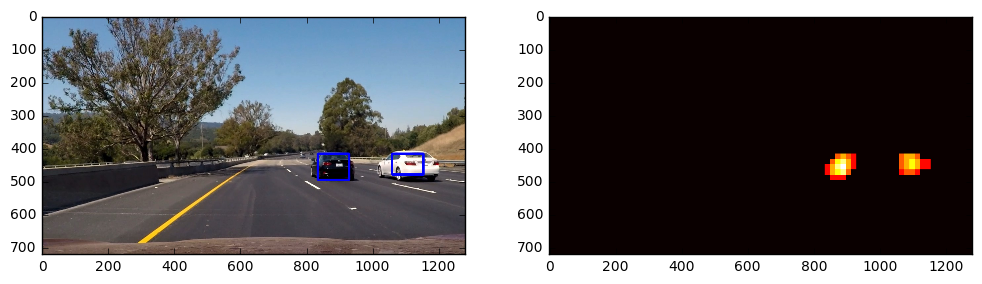

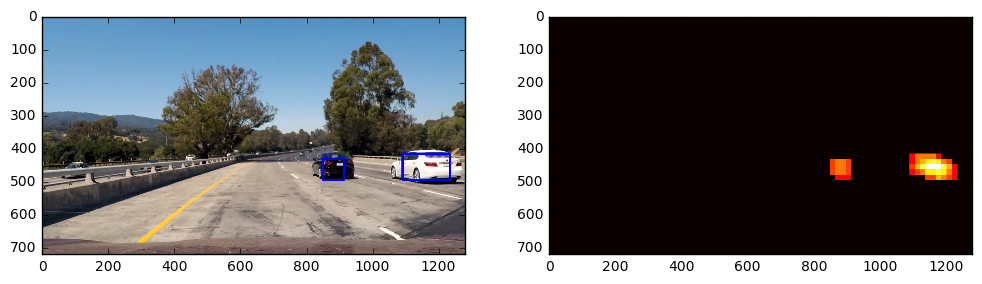

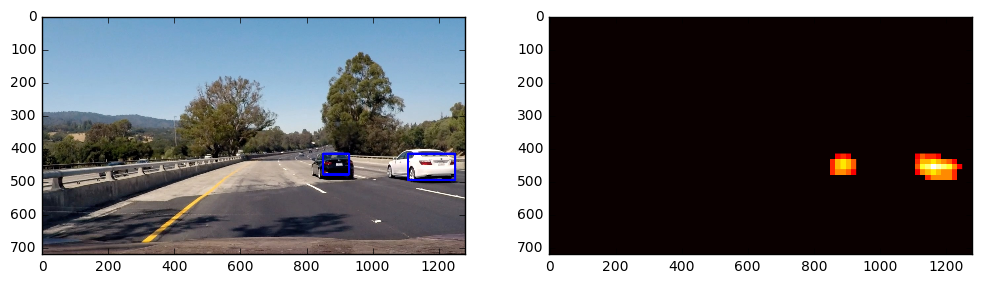

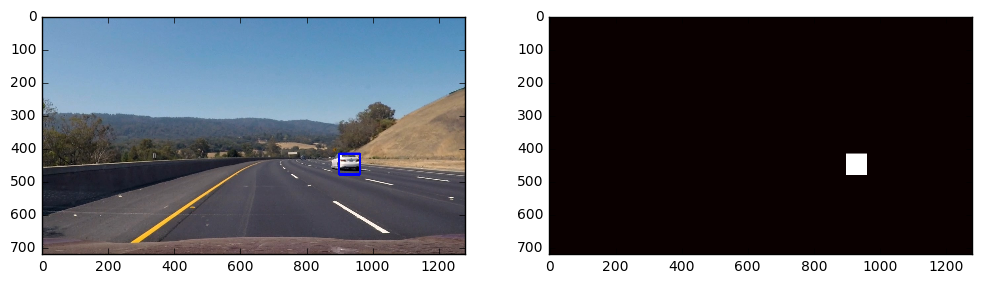

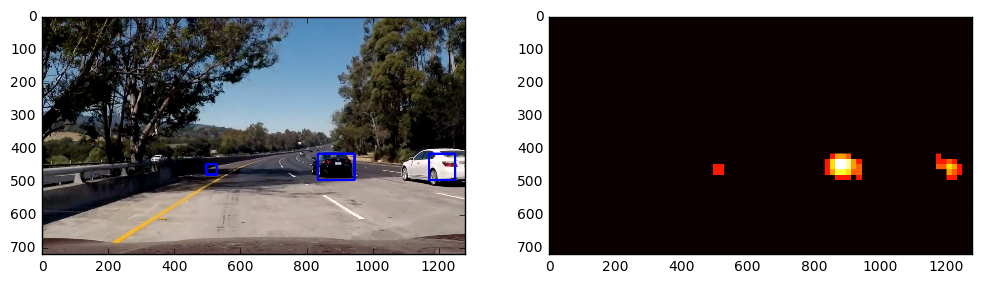

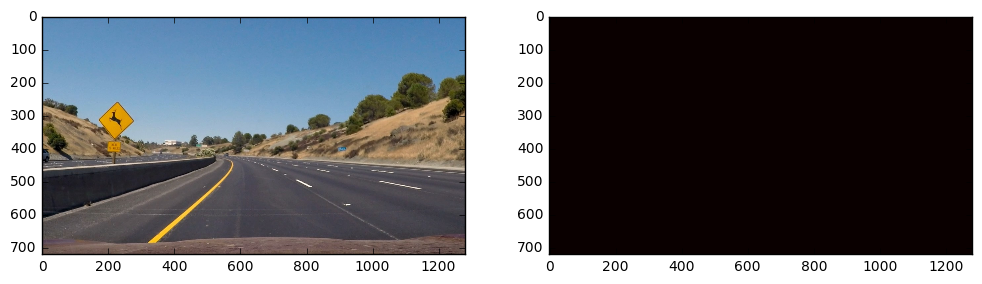

In [110]:
images = glob.glob('test_images/*.jpg')
for filename in images:
    image = mpimg.imread(filename)
    heatmap = np.zeros(image.shape[:2])
    draw_image = find_cars(image, heatmap, 400, 528, 1)
    draw_image = find_cars(image, heatmap, 500, 628, 2, draw_image=draw_image)
    
    threshold = np.max(heatmap) * 0.3
    heatmap = apply_threshold(heatmap, threshold)
    labels = image_label(heatmap)
    draw_image = draw_labeled_bboxes(np.copy(image), labels)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(draw_image)
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.show()


## Video Implementation

### 1. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

In [168]:
class VideoClipCarFinder():
    def __init__(self):
        self.last_heatmap = np.zeros(image.shape[:2])
        
    def process(self, image):
            heatmap = np.zeros(image.shape[:2])
            find_cars(image, heatmap, 400, 528)
            find_cars(image, heatmap, 500, 628, 2)

            threshold = np.max(heatmap) * 0.3
            heatmap = heatmap + cv2.GaussianBlur(self.last_heatmap, (9, 9), 0) * 0.5
            heatmap = apply_threshold(heatmap, threshold)
            labels = image_label(heatmap)
            draw_image = draw_labeled_bboxes(np.copy(image), labels)
            self.last_heatmap = heatmap
            
#             plt.figure(figsize=(12, 6))
#             plt.subplot(121)
#             plt.imshow(draw_image)
#             plt.subplot(122)
#             plt.imshow(heatmap, cmap='hot')
#             plt.show()
            return draw_image

video_clip_car_finder = VideoClipCarFinder()

# Transform the video
video_output = 'project_video_output.mp4'
# clip = VideoFileClip('test_video.mp4').fl_image(video_clip_car_finder.process)
clip = VideoFileClip('project_video.mp4').fl_image(video_clip_car_finder.process)
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<16:18,  1.29it/s]


  0%|          | 2/1261 [00:01<16:17,  1.29it/s]


  0%|          | 3/1261 [00:02<16:17,  1.29it/s]


  0%|          | 4/1261 [00:03<16:17,  1.29it/s]


  0%|          | 5/1261 [00:03<16:14,  1.29it/s]


  0%|          | 6/1261 [00:04<16:07,  1.30it/s]


  1%|          | 7/1261 [00:05<16:19,  1.28it/s]


  1%|          | 8/1261 [00:06<16:09,  1.29it/s]


  1%|          | 9/1261 [00:06<15:54,  1.31it/s]


  1%|          | 10/1261 [00:07<15:50,  1.32it/s]


  1%|          | 11/1261 [00:08<15:54,  1.31it/s]


  1%|          | 12/1261 [00:09<16:07,  1.29it/s]


  1%|          | 13/1261 [00:10<16:24,  1.27it/s]


  1%|          | 14/1261 [00:10<16:40,  1.25it/s]


  1%|          | 15/1261 [00:11<16:45,  1.24it/s]


  1%|▏         | 16/1261 [00:12<16:41,  1.24it/s]


  1%|▏         | 17/1261 [00:13<16:49,  1.23it/s]


  1%|▏         | 18/1261 [00:14<16:29,  1.26it/s]


  2%|▏         | 19/1261 [0

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 22min 17s, sys: 7.35 s, total: 22min 24s
Wall time: 16min 20s


In [171]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

- Modify the hyper parameters of classifier and features.
- Use the heatmap and threshold to remove the false positives.
- Use a dynamic threshold try to filter most false positive.
- Use the heatmap of last frame, blur it and plus to the current heatmap.
- Filter the small peaces in the heatmap.
- Use `scipy.ndimage.measurements.label` to combine the overlapping boxes.
- Try to modify the class weight in SVC, but nothing happends.


## Discussion

### Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

#### Problems / Issues
- I think the PCA can reduce the size of features, and can reduce the predict time. But in my tests, it seems nothing hannpeds.
- I have split the test set and get a good score, 98.76%. But if I reduce the `NBINS`, I've got a bad score, but less false positive for the test images.
- Although I've try to reduce the false positives, there are lot lot of false positives in the video. Maybe I can add more non-vehicle samples to avoid this.
- When the cars are overlaped together, they will be detected for one car. Maybe I can use their color and some algorithm to split them.

#### Where will your pipeline likely fail?

- If there are lot of cars in the image, the prediction result will be not very well.
- If there are lot of false positives, it will interfere the vehicle rectangles.
- When the cars appears far and near at the same time, the threshold will not work very will, because the far cars will get a low value of heatmap.

#### What could you do to make it more robust?

- Use color of cars and find some kind of algorithm to split the overlaped cars.
- Add more samples, maybe using ROC or False Positive Rate to score the prediction result.
- Add the heatmap weight of far windows, or just ignore the far cars.